In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path
from omegaconf import OmegaConf
from gluefactory.datasets import get_dataset
from gluefactory.utils.tensor import batch_to_device
import torch

torch.set_grad_enabled(True)
images = Path("assets")


from gluefactory.models import get_model
from matplotlib import pyplot as plt
import numpy as np

In [2]:
conf = OmegaConf.load("../gluefactory/configs/superpoint+simpleglue_homography_debug.yaml")

In [3]:
device= 'cpu'

In [4]:
data_conf = (conf.data)
dataset = get_dataset(data_conf.name)(data_conf)

[08/30/2025 13:51:48 gluefactory.datasets.base_dataset INFO] Creating dataset HomographyDataset
[08/30/2025 13:51:48 gluefactory.datasets.homographies INFO] Found 8 images in list file.


In [5]:
train_loader = dataset.get_data_loader("train", distributed=False)


In [6]:
model = get_model(conf.model.name)(conf.model).to(device)

Initialize state from lightglue for training


In [7]:
# train the model
torch.autograd.set_detect_anomaly(False)
tot_steps = 1000
log_interval = 10
lr = 1e-5
params = [(n, p) for n, p in model.named_parameters() if p.requires_grad]
all_params = [p for n, p in params]
optimizer = torch.optim.Adam(all_params, lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
        lr, tot_steps, pct_start=0.01, cycle_momentum=False, anneal_strategy='linear')

step = 0
data = next(iter(train_loader))
data = batch_to_device(data, device, non_blocking=True)
data.update({'tr_logvar': False})
start_tr_logvar = tot_steps // 20
while(step < tot_steps):
    # for _, data in enumerate(train_loader):
        if step >= start_tr_logvar:
            data.update({'tr_logvar': True})
        model.train()
        optimizer.zero_grad()
        pred = model(data)
        losses, _ = model.loss(pred, data)
        loss = torch.mean(losses["total"])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(all_params, conf.train.clip_grad)
        optimizer.step()
        scheduler.step()
        if step % log_interval == 0:
            print(f"Step {step}/{tot_steps}- lr: {scheduler.get_last_lr()} - Loss total: {loss.item()}, Last rpr Loss: {losses['last_rp'].item()}, Last lagvar Loss: {losses['last_logvar'].item()}")
        step += 1

Step 0/1000- lr: [1.4666666666666667e-06] - Loss total: 6260.5478515625, Last rpr Loss: 6157.0947265625, Last lagvar Loss: 0.0
Step 10/1000- lr: [9.979798060606061e-06] - Loss total: 6216.43505859375, Last rpr Loss: 6141.453125, Last lagvar Loss: 0.0
Step 20/1000- lr: [9.878788363636365e-06] - Loss total: 6177.98779296875, Last rpr Loss: 6138.9169921875, Last lagvar Loss: 0.0
Step 30/1000- lr: [9.777778666666668e-06] - Loss total: 6161.3671875, Last rpr Loss: 6138.05126953125, Last lagvar Loss: 0.0
Step 40/1000- lr: [9.67676896969697e-06] - Loss total: 6152.818359375, Last rpr Loss: 6137.6787109375, Last lagvar Loss: 0.0
Step 50/1000- lr: [9.575759272727274e-06] - Loss total: 40863.2109375, Last rpr Loss: 63760.0, Last lagvar Loss: -0.7712423205375671
Step 60/1000- lr: [9.474749575757576e-06] - Loss total: 6730.28857421875, Last rpr Loss: 5780.21826171875, Last lagvar Loss: 0.12871244549751282
Step 70/1000- lr: [9.37373987878788e-06] - Loss total: 2604.424560546875, Last rpr Loss: 525.

In [11]:
def plot_p_and_var(tmp_n, kps_tgt, proj, r_square, p_tgt_src, log_var, w = 640, h = 480, tp = False):
    var = torch.exp(log_var).squeeze().detach().cpu().numpy()
    kps_tgt = kps_tgt.squeeze().detach().cpu().numpy().astype(int) # target

    if tp:
        r_square = r_square.transpose(-2, -3)
        p_tgt_src = p_tgt_src.transpose(-1, -2)
    r_square_n_x = r_square.squeeze().detach()[tmp_n, :, 0].cpu().numpy()
    r_square_n_y = r_square.squeeze().detach()[tmp_n, :, 1].cpu().numpy()
    # dist = F.softmax(logits[0, 0], dim=0).detach().cpu().numpy()
    dist = p_tgt_src.squeeze()[tmp_n].detach().cpu().numpy()

    print(f'Max categorical weight {dist.max()} and weight sum {dist.sum()}')
    print(f"Min residual_sq x {r_square_n_x.min()}, Max {r_square_n_x.max()}")
    print(f"Min residual_sq y {r_square_n_y.min()}, Max {r_square_n_y.max()}")
    print(f"Weigted residual_sq sum x {(r_square_n_x * dist).sum()}")
    print(f"Weigted residual_sq sum y {(r_square_n_y * dist).sum()}")

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.bar(kps_tgt[:, 0], dist, width=1, alpha=0.5)
    ax2.bar(kps_tgt[:, 1], dist, width=1, alpha=0.5)
    ax1.bar(kps_tgt[:, 0], r_square_n_x**0.5 / 100, width=1, color='r', alpha=0.1)
    ax2.bar(kps_tgt[:, 1], r_square_n_y**0.5 / 100, width=1, color='r', alpha=0.1)

    kp0_proj1_x = proj.squeeze()[tmp_n, 0].detach().cpu().numpy()
    kp0_proj1_y = proj.squeeze()[tmp_n, 1].detach().cpu().numpy() # point 80 projected in image 0
    variance_x = var[tmp_n, 0]
    variance_y = var[tmp_n, 1]
    from scipy.stats import norm

    print(f'Var x: {variance_x}, Var y: {variance_y}')
    w_x = np.linspace(0, w, 100)
    w_x = np.sort(np.append(w_x, kp0_proj1_x))
    w_y = norm.pdf(w_x, kp0_proj1_x, variance_x**0.5)
    h_x = np.linspace(0, h, 100)
    h_x = np.sort(np.append(h_x, kp0_proj1_y))
    h_y = norm.pdf(h_x, kp0_proj1_y, variance_y**0.5)
    # set ylim
    ax1.set_ylim([0, 2.2])
    ax2.set_ylim([0, 2.2])
    ax1.plot(w_x, w_y, 'g--')
    ax2.plot(h_x, h_y, 'g--')

Max categorical weight 0.9996675252914429 and weight sum 1.0
Min residual_sq x 0.002705393359065056, Max 25817.1015625
Min residual_sq y 0.06190347298979759, Max 10815.75
Weigted residual_sq sum x 11.514983177185059
Weigted residual_sq sum y 5.072816371917725
Var x: 18.664949417114258, Var y: 2.5270509719848633


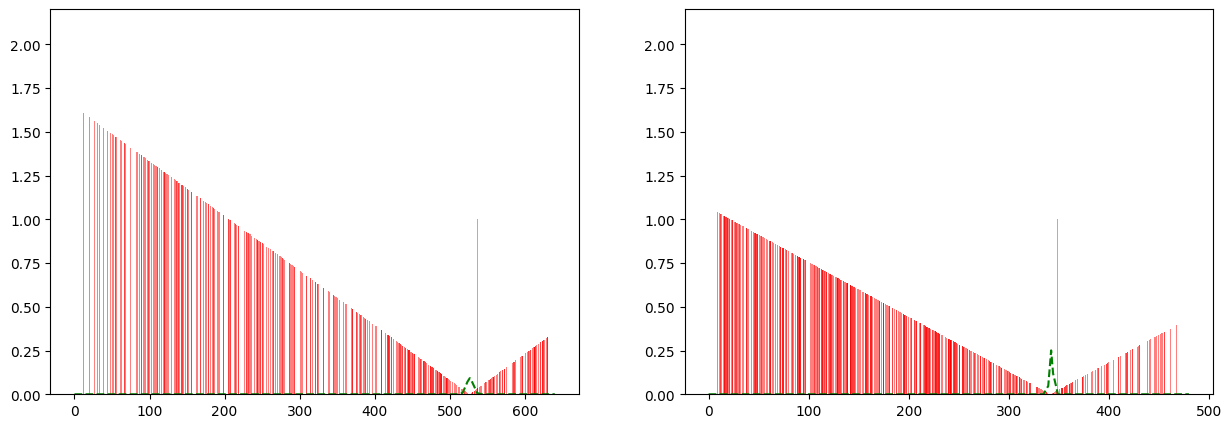

In [9]:
plot_p_and_var(0, pred['keypoints1'], pred['gt_proj_0to1'], pred['gt_res0_1_sq'], pred['p_rp_01'], pred['logvar_01'])

Max categorical weight 0.9733284711837769 and weight sum 1.0
Min residual_sq x 40000.0, Max 40000.0
Min residual_sq y 40000.0, Max 40000.0
Weigted residual_sq sum x 39999.99609375
Weigted residual_sq sum y 39999.99609375
Var x: 31982.09375, Var y: 24273.888671875


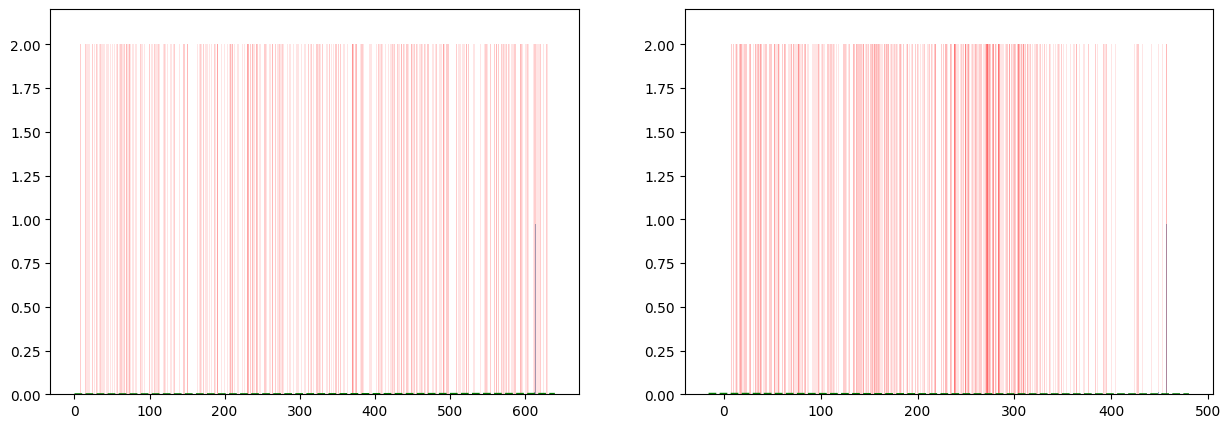

In [12]:
plot_p_and_var(0, pred['keypoints0'], pred['gt_proj_1to0'], pred['gt_res1_0_sq'], pred['p_rp_10'], pred['logvar_10'])

In [13]:
p_idx_10_of_N = torch.argmax(pred['p_rp_10'][0][0])
res_of_N = pred['gt_res1_0_sq'][0][0][p_idx_10_of_N]
proj_of_N = pred['keypoints0'][0][p_idx_10_of_N]
print(res_of_N)
print(proj_of_N)

tensor([40000., 40000.])
tensor([614.5000, 457.5000])


In [25]:
pred['keypoints0'].shape

torch.Size([1, 512, 2])

In [11]:

def plot_var_stats(var):
    print(f'Max and Min and Median var_01 x: {var[:, 0].max()}, {var[:, 0].min()}, {var[:, 0].median()}')
    print(f'Max and Min and Median var_01 y: {var[:, 1].max()}, {var[:, 1].min()}, {var[:, 1].median()}')
    var= var.numpy()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.hist(var[:, 0], bins=100)
    ax2.hist(var[:, 1], bins=100)

In [12]:
pred['logvar_10'].squeeze()[:,:1].min(0)

torch.return_types.min(
values=tensor([-3.9366], grad_fn=<MinBackward0>),
indices=tensor([95]))

In [13]:
pred['logvar_10'].mean()

tensor(0.0906, grad_fn=<MeanBackward0>)

Max and Min and Median var_01 x: 835.6142578125, 0.013304498977959156, 0.6326177716255188
Max and Min and Median var_01 y: 42.81559753417969, 0.015353546477854252, 1.570909857749939


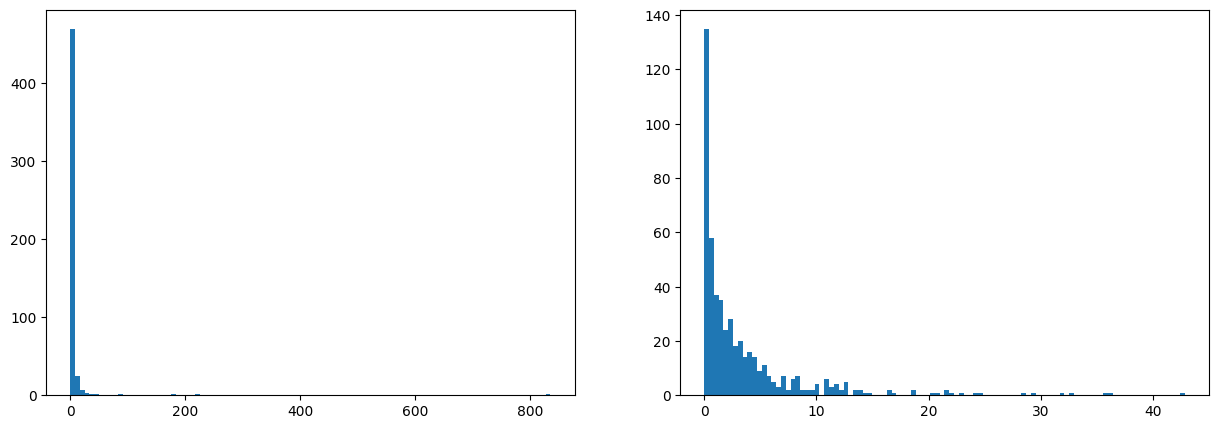

In [14]:
var_01 = torch.exp(pred['logvar_01']).squeeze().detach().cpu()
plot_var_stats(var_01)

Max and Min and Median var_01 x: 83.62934112548828, 0.019514502957463264, 0.822110116481781
Max and Min and Median var_01 y: 43.42755126953125, 0.019890394061803818, 1.608588457107544


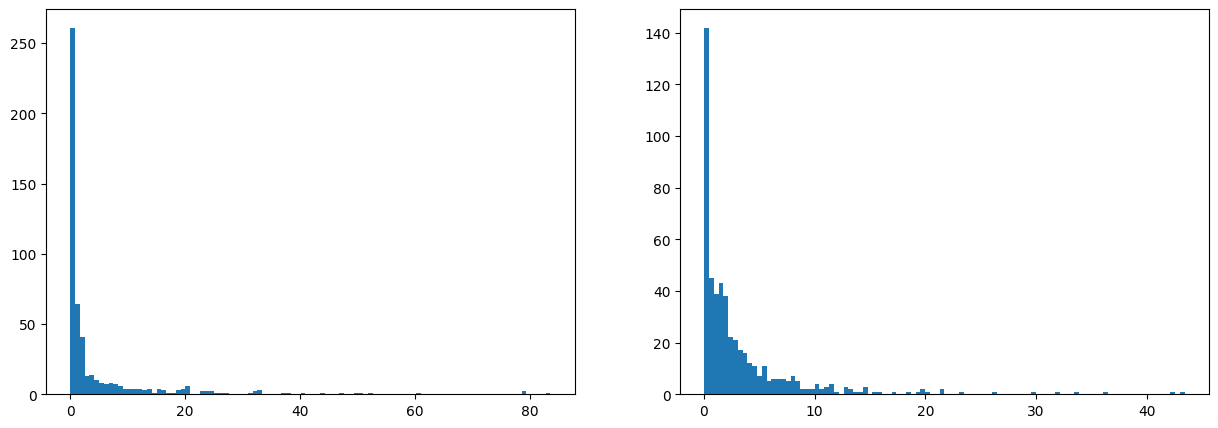

In [15]:
var_10 = torch.exp(pred['logvar_10']).squeeze().detach().cpu()
plot_var_stats(var_10)

In [16]:
import cv2

def draw_keypoints_cv(image, kps, color = (0, 255, 0), select_kp = None):
  if image.shape[1] == 3:  # RGB
    scale = image.new_tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)
    image = (image * scale).sum(1, keepdim=True)
  image = image.squeeze().detach().cpu().numpy()
  image = (image * 255).astype(np.uint8)
  kps = kps.squeeze().detach().cpu().numpy()
    
  cv_kps= [cv2.KeyPoint(kp[0], kp[1], 1) for kp in kps]
  out_img = cv2.drawKeypoints(image, cv_kps, None, color=color, flags=0)

  if select_kp is not None:
    for kp in select_kp:
      cv2.circle(out_img, (int(kps[kp][0]), int(kps[kp][1])), 5, (255, 0, 0), -1)

  return out_img

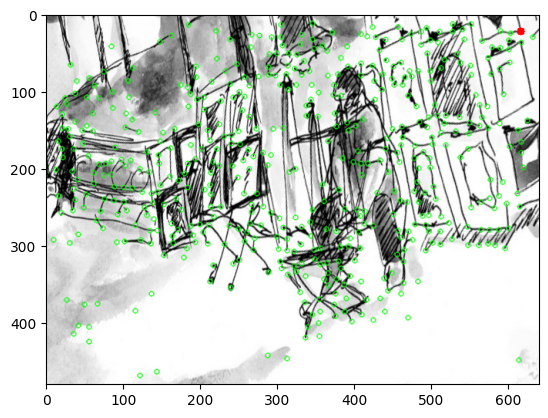

In [17]:
img0 = draw_keypoints_cv(data['view0']['image'], pred['keypoints0'], color=(0,255,0), select_kp=[266])
plt.imshow(img0)
plt.show()

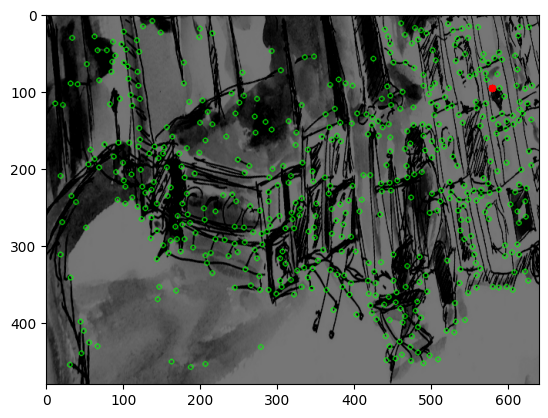

In [18]:
img1 = draw_keypoints_cv(data['view1']['image'], pred['keypoints1'], color=(0,255,0), select_kp=[0])
plt.imshow(img1)
plt.show()

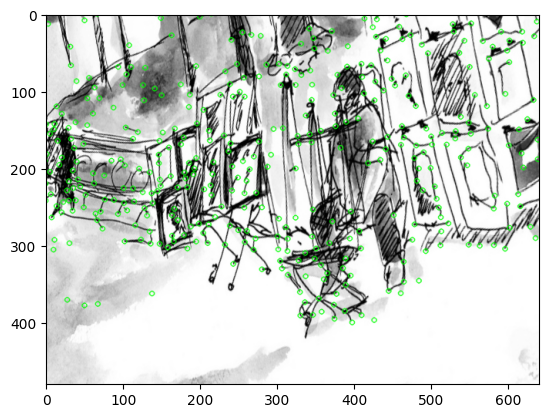

In [19]:
img1_0 = draw_keypoints_cv(data['view0']['image'], pred['gt_proj_1to0'], color=(0,255,0), select_kp=[0])
plt.imshow(img1_0)
plt.show()

In [128]:
for key in pred:
    print(key)

keypoints0
keypoint_scores0
descriptors0
keypoints1
keypoint_scores1
descriptors1
matches0
matches1
matching_scores0
matching_scores1
ref_descriptors0
ref_descriptors1
prune0
prune1
p_rp_01
p_rp_10
logvar_01
logvar_10
gt_assignment
gt_reward
gt_matches0
gt_matches1
gt_matching_scores0
gt_matching_scores1
gt_proj_0to1
gt_proj_1to0
gt_valid0_1
gt_valid1_0
gt_res0_1_sq
gt_res1_0_sq


In [132]:
pred['logvar_10'].shape

torch.Size([1, 512, 2])

tensor(5)


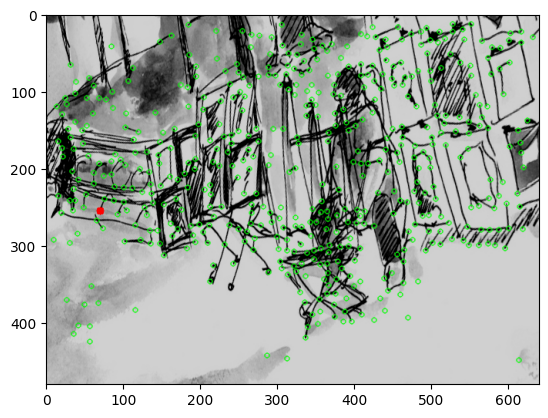

In [123]:
prob_1_0_of_Nth = pred['p_rp_10'][0][0]
est_Nth = torch.argmax(prob_1_0_of_Nth, -1)
print(est_Nth)
img0 = draw_keypoints_cv(data['view0']['image'], pred['keypoints0'], color=(0,255,0), select_kp=[est_Nth])
plt.imshow(img0)
plt.show()

In [99]:
def draw_stats(data):
    # arg: data Nx2
    print(f'Max and Min and Median x: {data[:, 0].max()}, {data[:, 0].min()}, {data[:, 0].median()}')
    print(f'Max and Min and Median y: {data[:, 1].max()}, {data[:, 1].min()}, {data[:, 1].median()}')
    data= data.numpy()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # draw x, y value as bar chart
    ax1.bar(np.arange(len(data)), data[:, 0])
    ax1.set_title('X values')
    ax2.bar(np.arange(len(data)), data[:, 1])
    ax2.set_title('Y values')

In [100]:
res0_1_sq = pred["gt_res0_1_sq"][0]
res1_0_sq = pred["gt_res1_0_sq"][0]

dist0_min = torch.sum(res0_1_sq, -1).min(-1).values
best_idx0 = torch.argmin(dist0_min)
worst_idx0 = torch.argmax(dist0_min)
dist1_min = torch.sum(res1_0_sq, -1).min(-1).values
best_idx1 = torch.argmin(dist1_min)
worst_idx1 = torch.argmax(dist1_min)


Max and Min and Median x: 12448.1513671875, 7.714707317063585e-05, 2316.861083984375
Max and Min and Median y: 10189.76953125, 4.747619095724076e-05, 881.7567749023438
Max and Min and Median x: 15086.162109375, 0.0001750919473124668, 2169.298583984375
Max and Min and Median y: 12514.2431640625, 6.276836938923225e-05, 1035.525146484375


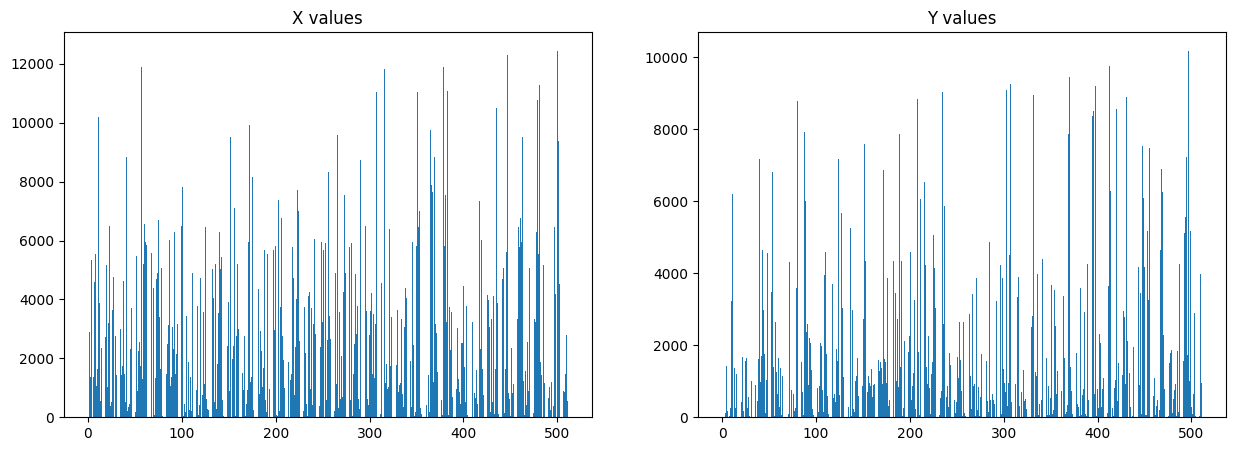

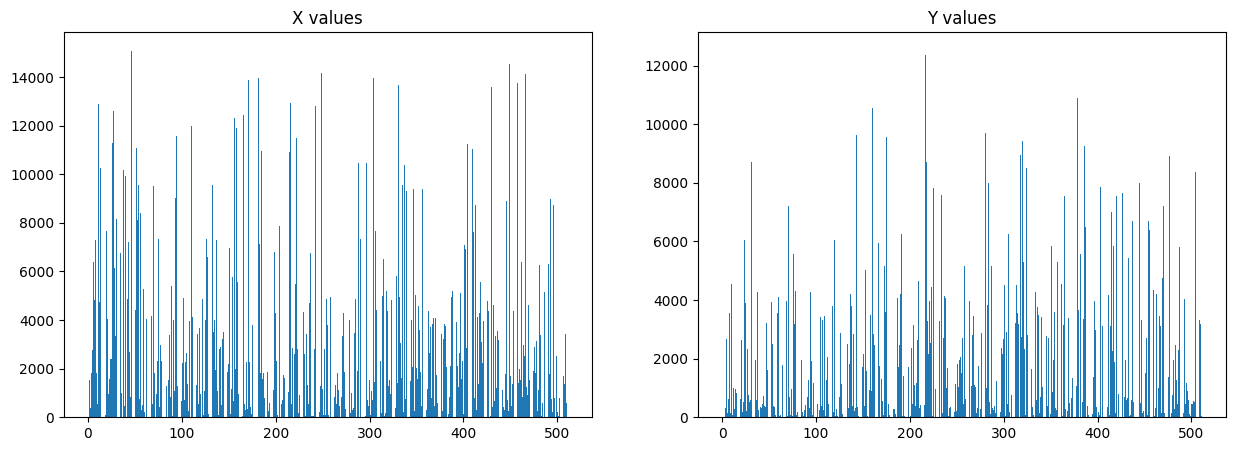

In [101]:
draw_stats(res0_1_sq[best_idx0, ...])
draw_stats(res1_0_sq[best_idx1, ...])

Max and Min and Median x: 40000.0, 40000.0, 40000.0
Max and Min and Median y: 40000.0, 40000.0, 40000.0
Max and Min and Median x: 40000.0, 40000.0, 40000.0
Max and Min and Median y: 40000.0, 40000.0, 40000.0


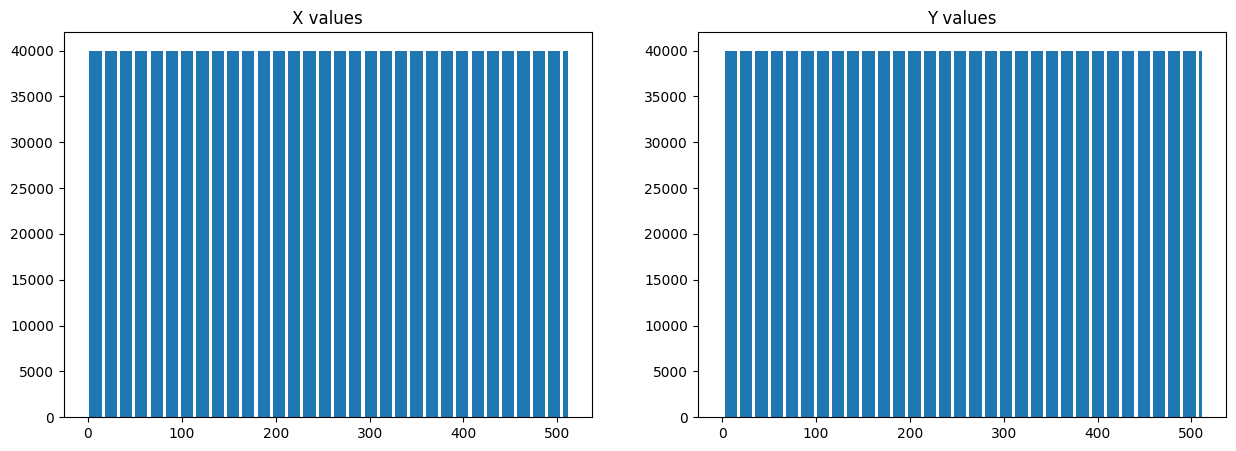

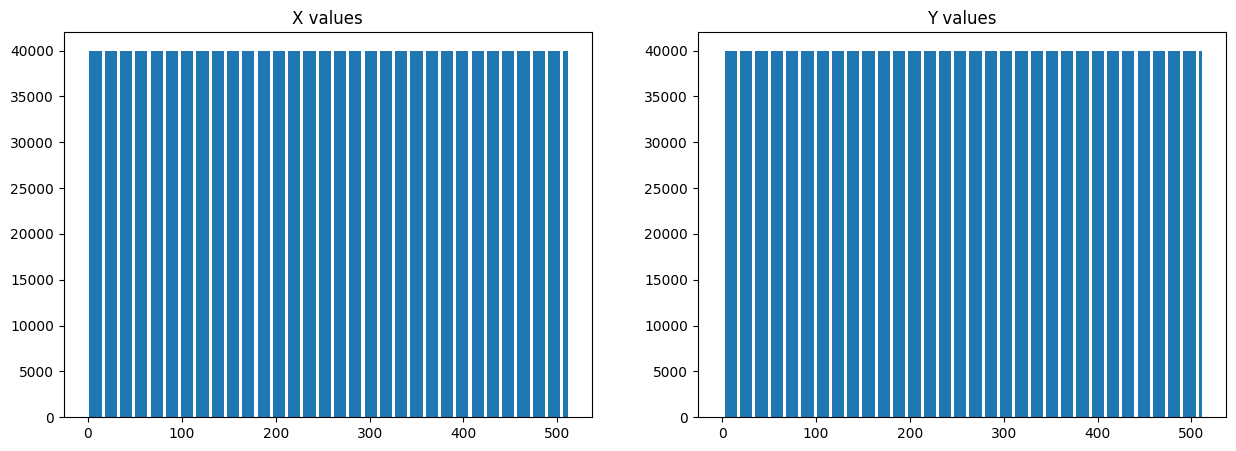

In [102]:
draw_stats(res0_1_sq[worst_idx0, ...])
draw_stats(res1_0_sq[worst_idx1, ...])

In [105]:
worst_idx1

tensor(0)